# Import Libraries

In [1]:
import calendar
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
#from lightgbm import LGBMClassifierx

# Import Dataset

In [2]:
data = pd.read_csv("startup_data_1.csv")
data.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


In [3]:
list(data.columns)

['Unnamed: 0',
 'state_code',
 'latitude',
 'longitude',
 'zip_code',
 'id',
 'city',
 'Unnamed: 6',
 'name',
 'labels',
 'founded_at',
 'closed_at',
 'first_funding_at',
 'last_funding_at',
 'age_first_funding_year',
 'age_last_funding_year',
 'age_first_milestone_year',
 'age_last_milestone_year',
 'relationships',
 'funding_rounds',
 'funding_total_usd',
 'milestones',
 'state_code.1',
 'is_CA',
 'is_NY',
 'is_MA',
 'is_TX',
 'is_otherstate',
 'category_code',
 'is_software',
 'is_web',
 'is_mobile',
 'is_enterprise',
 'is_advertising',
 'is_gamesvideo',
 'is_ecommerce',
 'is_biotech',
 'is_consulting',
 'is_othercategory',
 'object_id',
 'has_VC',
 'has_angel',
 'has_roundA',
 'has_roundB',
 'has_roundC',
 'has_roundD',
 'avg_participants',
 'is_top500',
 'status']

# Data Cleaning

In [4]:
# Define the data cleaning function
def clean_data(data):
    
    # Count initial number of rows
    initial_row_count = data.shape[0]
     
    data = (
            # Drop columns that are not needed
            data.drop(columns=["Unnamed: 0", "latitude", "longitude", "id", "Unnamed: 6", 
                               "object_id", "labels", "state_code.1", "closed_at", "state_code", "category_code"])
        
            # Transform status into binary
            .assign(status=lambda x: (x["status"] == "acquired").astype(int)) 
            
            # One-hot encode city and zip_code
            .pipe(pd.get_dummies, columns=['city', 'zip_code'], prefix=['city', 'zip_code']) 
            
            # Convert dates and create new columns
            .assign(founded_at=lambda x: pd.to_datetime(x['founded_at']),
                      first_funding_at=lambda x: pd.to_datetime(x['first_funding_at']),
                      last_funding_at=lambda x: pd.to_datetime(x['last_funding_at']),
                      amt_days_bw_found_first_fund=lambda x: (x['first_funding_at'] - x['founded_at']).dt.days,
                      founding_month=lambda x: x['founded_at'].dt.month) 
            
            # Drop the original date columns
            .drop(columns=['founded_at', 'first_funding_at', 'last_funding_at']) 
            
            # Drop rows with NA values
            .dropna() 
           )
    
    # Calculate the number and percentage of rows dropped
    rows_dropped = initial_row_count - data.shape[0]
    dropped_percentage = (rows_dropped / initial_row_count) * 100

    # Display the number and percentage of rows dropped
    print(f"Dropped {rows_dropped} rows due to missing values ({dropped_percentage:.2f}% of total).")

    # Export the cleaned data
    data.to_csv('1102_startup_data_cleaned.csv', encoding='utf-8', index=False)
    
    return data

# Clean the loaded data
data_clean = clean_data(data)

# Display the shape and columns of the cleaned data
print(f"Data shape: {data_clean.shape}")
#print(f"Data columns: {list(data_clean.columns)}")

Dropped 152 rows due to missing values (16.47% of total).
Data shape: (771, 638)


# Preliminary Analysis

<Figure size 1200x800 with 0 Axes>

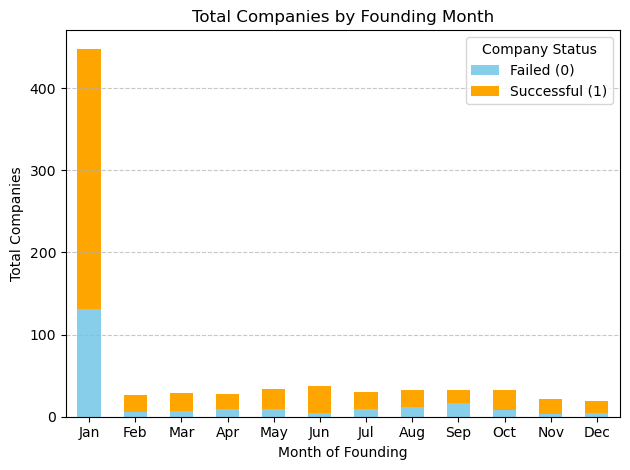

In [5]:
# Plotting without percentages
plt.figure(figsize=(12, 8))
grouped_data = data_clean.groupby('founding_month')['status'].value_counts().unstack().fillna(0)
grouped_data.plot(kind='bar', stacked=True, color=['skyblue', 'orange'])

# Adding labels and title
plt.xlabel('Month of Founding')
plt.ylabel('Total Companies')
plt.title('Total Companies by Founding Month')

# Customizing ticks
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation='horizontal')

# Adding legend and grid
plt.legend(title='Company Status', labels=['Failed (0)', 'Successful (1)'], loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

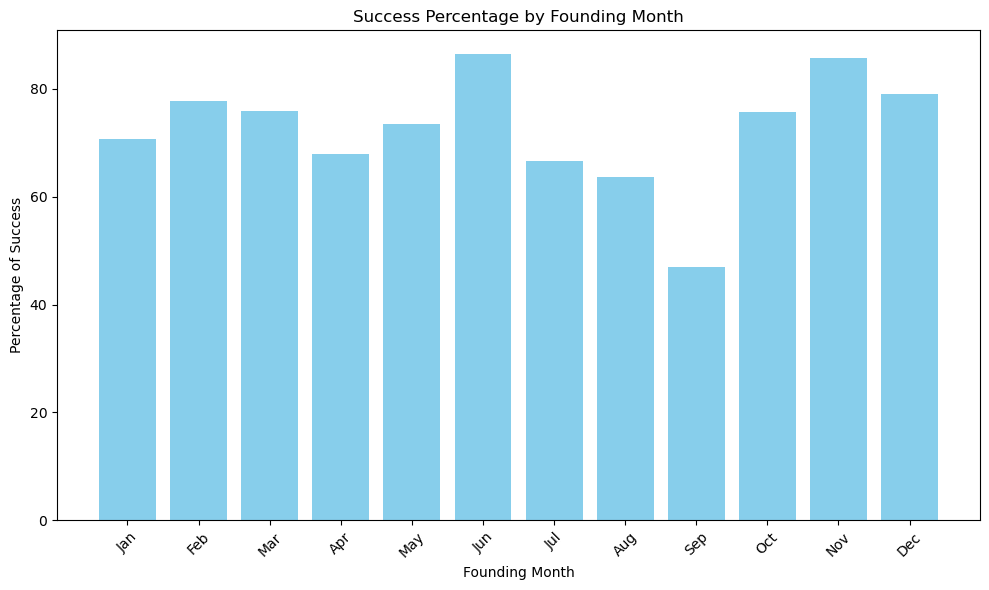

In [6]:
# Rename columns for clarity
grouped_data = grouped_data.rename(columns={0: 'Failures', 1: 'Successes'})

# Calculate the percentage of success
grouped_data['Success Percentage'] = grouped_data.apply(lambda x: 100 * x['Successes'] / (x['Successes'] + x['Failures']), axis=1)

# Reset index to use 'founding_month' as a column
grouped_data = grouped_data.reset_index()

# Assign correct month values
grouped_data['founding_month'] = grouped_data['founding_month'].apply(lambda x: calendar.month_abbr[x])

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(grouped_data['founding_month'], grouped_data['Success Percentage'], color='skyblue')

# Adding labels and title
plt.xlabel('Founding Month')
plt.ylabel('Percentage of Success')
plt.title('Success Percentage by Founding Month')

# Ensure all month labels are shown on x-axis
plt.xticks(ticks=range(len(grouped_data['founding_month'])), labels=grouped_data['founding_month'], rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


checking if the month of founding have an effect on the success = No

### Understanding frequency of numerical variables

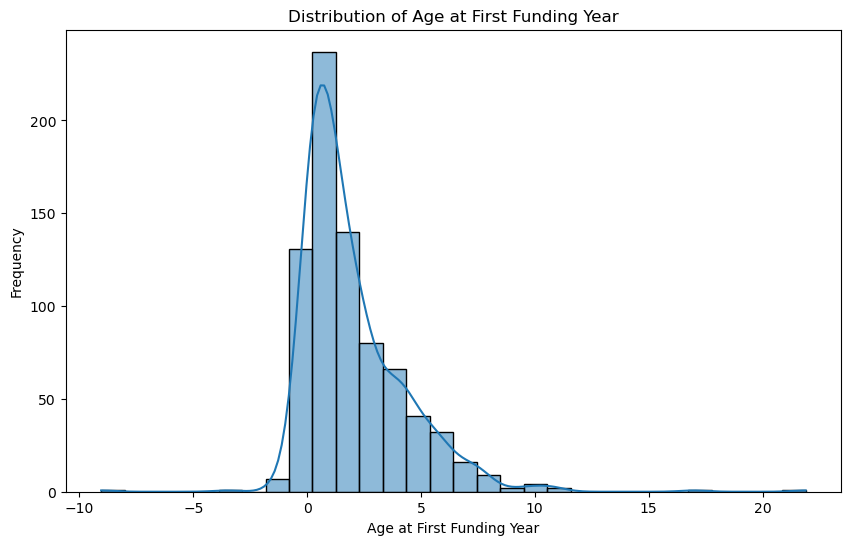

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example for 'age_first_funding_year'
plt.figure(figsize=(10, 6))
sns.histplot(data=data_clean, x='age_first_funding_year', bins=30, kde=True)
plt.title('Distribution of Age at First Funding Year')
plt.xlabel('Age at First Funding Year')
plt.ylabel('Frequency')
plt.show()


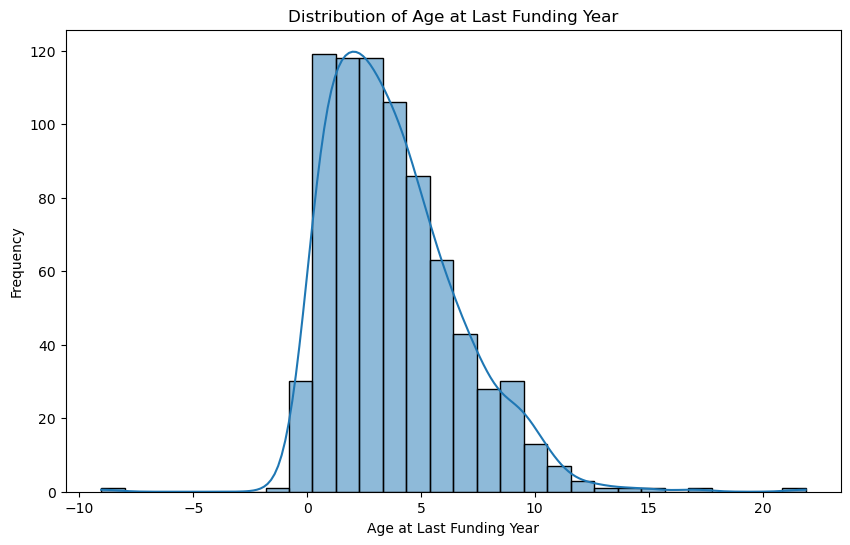

In [8]:
#Example for age_last_funding_year
plt.figure(figsize=(10, 6))
sns.histplot(data=data_clean, x='age_last_funding_year', bins=30, kde=True)
plt.title('Distribution of Age at Last Funding Year')
plt.xlabel('Age at Last Funding Year')
plt.ylabel('Frequency')
plt.show()


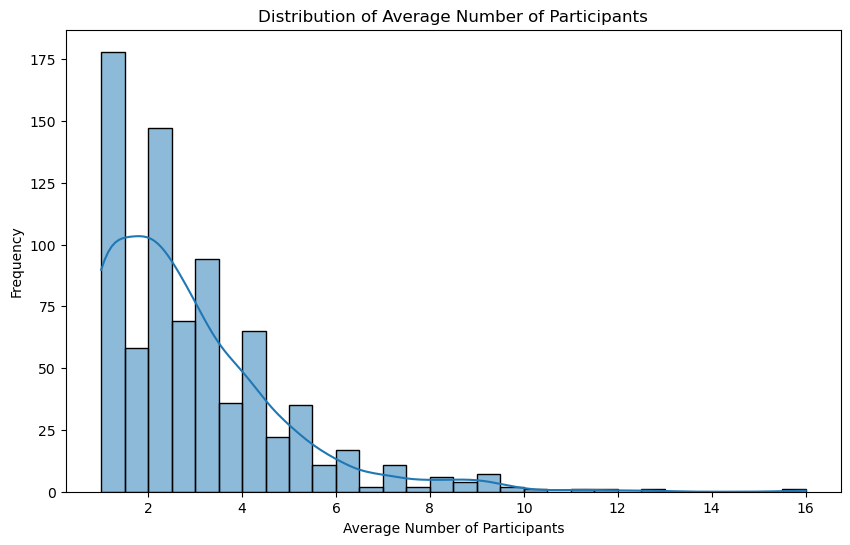

In [9]:
#Example for avg_participants
plt.figure(figsize=(10, 6))
sns.histplot(data=data_clean, x='avg_participants', bins=30, kde=True)
plt.title('Distribution of Average Number of Participants')
plt.xlabel('Average Number of Participants')
plt.ylabel('Frequency')
plt.show()

### Understanding Distribution of Categorical Variables

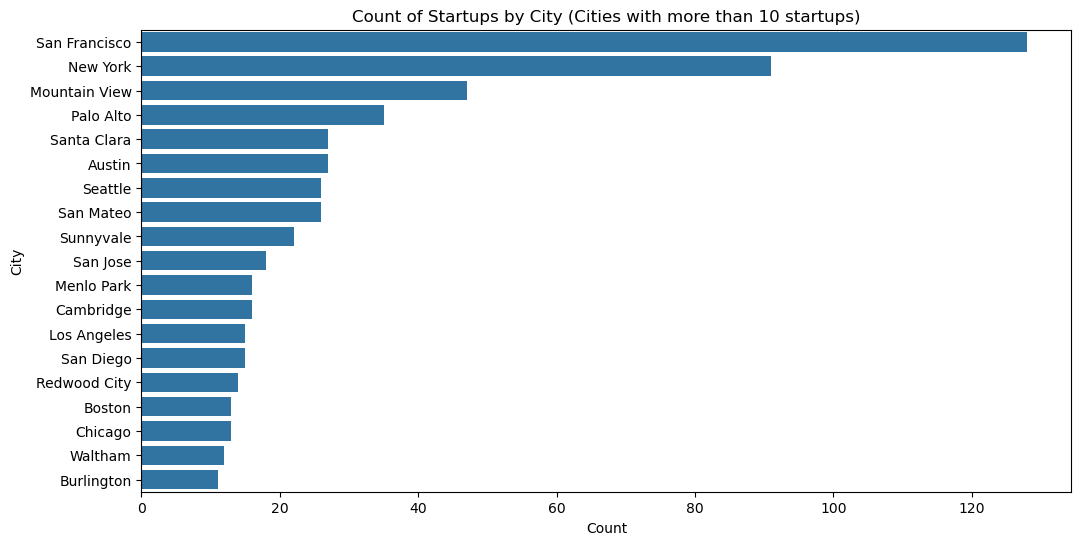

In [10]:
#Cities Represented (above a certain threshold of observations)

city_counts = data['city'].value_counts()
threshold = 10 
filtered_cities = city_counts[city_counts > threshold].index
filtered_data = data[data['city'].isin(filtered_cities)]

# Plotting
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_data, y='city', order=filtered_data['city'].value_counts().index)
plt.title('Count of Startups by City (Cities with more than {} startups)'.format(threshold))
plt.xlabel('Count')
plt.ylabel('City')
plt.show()


###  Funding by City

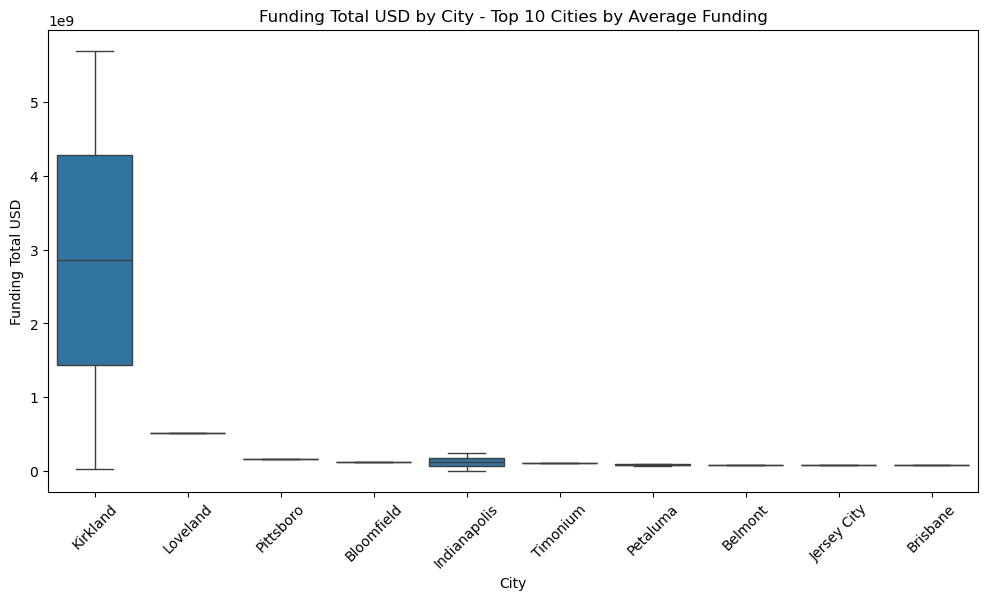

In [11]:
average_funding_by_city = data.groupby('city')['funding_total_usd'].mean()

# Determine the top N cities by average funding
N = 10  # Adjust this value based on your needs
top_cities_by_avg_funding = average_funding_by_city.nlargest(N).index

# Filter the DataFrame to include only these top cities
filtered_data = data[data['city'].isin(top_cities_by_avg_funding)]

# Plotting
plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='funding_total_usd', data=filtered_data, order=top_cities_by_avg_funding)
plt.title('Funding Total USD by City - Top {} Cities by Average Funding'.format(N))
plt.xticks(rotation=45)  # Rotate the x-labels for better readability
plt.xlabel('City')
plt.ylabel('Funding Total USD')
plt.show()

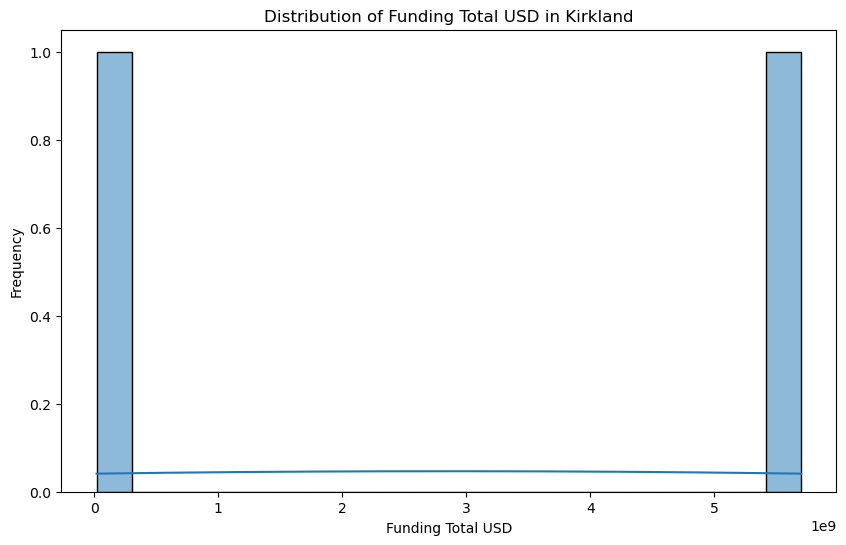

In [12]:
kirkland_data = data[data['city'] == 'Kirkland']

# Check if there are any entries for Kirkland
if not kirkland_data.empty:
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.histplot(kirkland_data['funding_total_usd'], bins=20, kde=True)
    plt.title('Distribution of Funding Total USD in Kirkland')
    plt.xlabel('Funding Total USD')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("No data available for Kirkland.")

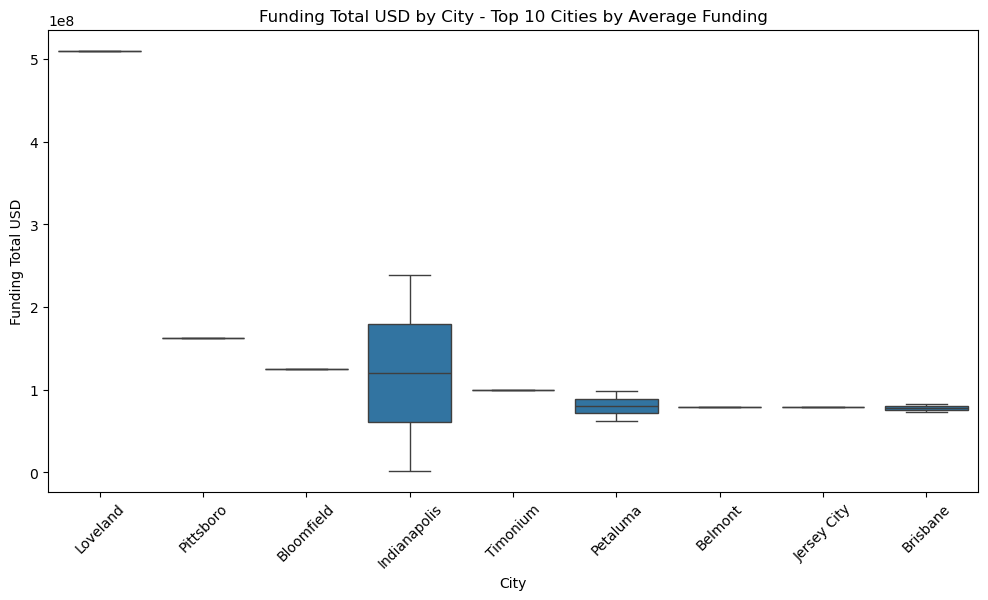

In [13]:
#drop Kirkland
average_funding_by_city = data.groupby('city')['funding_total_usd'].mean()

# Determine the top N cities by average funding
N = 10  # Adjust this value based on your needs
top_cities_by_avg_funding = average_funding_by_city.nlargest(N).index
top_cities_by_avg_funding = top_cities_by_avg_funding.drop("Kirkland")

# Filter the DataFrame to include only these top cities
filtered_data = data[data['city'].isin(top_cities_by_avg_funding)]

# Plotting
plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='funding_total_usd', data=filtered_data, order=top_cities_by_avg_funding)
plt.title('Funding Total USD by City - Top {} Cities by Average Funding'.format(N))
plt.xticks(rotation=45)  # Rotate the x-labels for better readability
plt.xlabel('City')
plt.ylabel('Funding Total USD')
plt.show()

In [14]:
#assess consistency in funding (avoiding outliers)
import pandas as pd

# Assuming df is your DataFrame

# Group data by city and calculate mean and standard deviation of funding
city_funding_stats = data.groupby('city')['funding_total_usd'].agg(['mean', 'std'])

# Calculate the coefficient of variation (std/mean)
# We handle division by zero by replacing infinities with NaN
city_funding_stats['cv'] = (city_funding_stats['std'] / city_funding_stats['mean']).replace([float('inf'), -float('inf')], pd.NA)

# Sort cities by coefficient of variation, lowest first (most consistent funding)
sorted_cities = city_funding_stats.sort_values(by='cv')

# Display the top cities with the most consistent funding
print(sorted_cities.head())


                    mean           std        cv
city                                            
Brisbane    7.800000e+07  7.071068e+06  0.090655
Acton       3.050000e+07  3.535534e+06  0.115919
Woburn      1.766667e+07  3.785939e+06  0.214298
Richardson  2.605500e+07  6.959030e+06  0.267090
Petaluma    8.038500e+07  2.515179e+07  0.312892


# Data Preparation

In [15]:
data_clean

,name,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,zip_code_98121,zip_code_98122,zip_code_98371,zip_code_98665,zip_code_99202,zip_code_CA 90245,zip_code_CA 94105,zip_code_Maryland 21045,amt_days_bw_found_first_fund,founding_month
0,Bandsintown,2.2493,3.0027,4.6685,6.7041,3,3,375000,3,1,...,False,False,False,False,False,False,False,False,821,1
1,TriCipher,5.1260,9.9973,7.0055,7.0055,9,4,40100000,1,1,...,False,False,False,False,False,False,False,False,1871,1
2,Plixi,1.0329,1.0329,1.4575,2.2055,5,1,2600000,2,1,...,False,False,False,False,False,False,False,False,377,3
3,Solidcore Systems,3.1315,5.3151,6.0027,6.0027,5,3,40000000,1,1,...,False,False,False,False,False,False,False,False,1143,1
4,Inhale Digital,0.0000,1.6685,0.0384,0.0384,2,2,1300000,1,1,...,False,False,False,False,False,False,False,False,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,CoTweet,0.5178,0.5178,0.5808,4.5260,9,1,1100000,2,1,...,False,False,False,False,False,False,False,False,189,1
919,Reef Point Systems,7.2521,9.2274,6.0027,6.0027,1,3,52000000,1,0,...,False,False,False,False,False,False,False,False,2647,1
920,Paracor Medical,8.4959,8.4959,9.0055,9.0055,5,1,44000000,1,1,...,False,False,False,False,False,False,False,False,3101,1
921,Causata,0.7589,2.8329,0.7589,3.8356,12,2,15500000,2,1,...,False,False,False,False,False,False,False,False,277,1


In [16]:
def prepare_balanced_data_for_modeling(data, target_column='status', test_size=0.2, random_state=42):
    # Separate rows with 'status' equal to 0 and 1
    status_0_data = data[data[target_column] == 0]
    status_1_data = data[data[target_column] == 1]

    # Randomly select a balanced number of rows from each class
    min_samples = min(len(status_0_data), len(status_1_data))
    balanced_data = pd.concat([
        status_0_data.sample(min_samples, random_state=random_state),
        status_1_data.sample(min_samples, random_state=random_state)
    ])

    # Drop columns that are not features
    features = balanced_data.drop(columns=[target_column, 'name', 'founding_month'])

    # Separate features (X) and target (y)
    X = features.copy()
    y = balanced_data[target_column]

    # Split the dataset into training and testing sets with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Concatenate the remaining rows from data_clean that were not used in the testing set
    unused_data = data_clean[~data_clean.index.isin(X_test.index)]
    X_test = pd.concat([X_test, unused_data.drop(columns=[target_column, 'name', 'founding_month'])])
    y_test = pd.concat([y_test, unused_data[target_column]])

    # Display class distribution in train and test sets
    print("Training set class distribution:")
    print(y_train.value_counts(normalize=True))  # Normalized value counts for y_train
    print("\nTesting set class distribution:")
    print(y_test.value_counts(normalize=True))  # Normalized value counts for y_test
    return X_train, X_test, y_train, y_test

# Call the function with your data
X_train, X_test, y_train, y_test = prepare_balanced_data_for_modeling(data_clean)

Training set class distribution:
status
1    0.501416
0    0.498584
Name: proportion, dtype: float64

Testing set class distribution:
status
1    0.713359
0    0.286641
Name: proportion, dtype: float64


# Methods

## 1. Sparse Logistic Regression

In [17]:
def sparse_regression_classifier(X_train, y_train, X_test, penalty='l1', solver='liblinear', random_state=42):
    
    # Initialize and fit the Lasso Logistic Regression model
    lasso_model = LogisticRegression(penalty=penalty, solver=solver, random_state=random_state)
    lasso_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = lasso_model.predict(X_test)

    # Extract features with non-zero coefficients
    selected_features = X_train.columns[(lasso_model.coef_ != 0).flatten()]
    coefficients = lasso_model.coef_[0][(lasso_model.coef_ != 0).flatten()]

    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': coefficients
    })

    # Filter columns to keep based on the model's feature importance
    all_features = list(summary_df['Feature'])
    columns_to_keep_lasso = [
        col for col in all_features if not col.startswith('city_') and not col.startswith('zip_code_')
    ]

    # Create reduced train and test sets based on selected features
    X_train_reduced = X_train[columns_to_keep_lasso]
    X_test_reduced = X_test[columns_to_keep_lasso]

    # Print Lasso selected features and their coefficients
    print("Lasso Selected Features and Coefficients:")
    print(summary_df)

    # Calculate accuracy and other metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of the Lasso model on the test set: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Number of features selected by Lasso
    print(f"Original number of features: {X_train.shape[1]}")
    print(f"Number of features selected by Lasso: {summary_df.shape[0]}")

    # Top features by absolute coefficient value
    top_features = summary_df.sort_values(by='Coefficient', key=abs, ascending=False).head(10)
    print("Top 10 features by absolute coefficient value:")
    print(top_features)

    # Features not selected by Lasso
    non_selected_features = set(X_train.columns) - set(summary_df['Feature'])
    print(f"Features not selected by Lasso: {non_selected_features}")

    return lasso_model, summary_df, X_train_reduced, X_test_reduced

# Call the function with your data
lasso_model, summary_df, X_train_reduced, X_test_reduced = sparse_regression_classifier(X_train, y_train, X_test)

Lasso Selected Features and Coefficients:
                         Feature   Coefficient
0          age_last_funding_year  9.135598e-02
1       age_first_milestone_year -2.237447e-02
2        age_last_milestone_year  2.298439e-01
3                  relationships  1.238694e-01
4              funding_total_usd -4.504385e-09
5                     milestones -2.192910e-01
6                          is_TX -4.801818e-01
7                  is_otherstate -5.288724e-01
8                    is_software  3.193431e-01
9                         is_web  1.919783e-01
10                 is_enterprise -2.461863e-02
11                is_advertising -6.357944e-04
12                 is_gamesvideo -6.895177e-01
13                  is_ecommerce -3.905599e-01
14                        has_VC -5.910258e-01
15                     has_angel -1.395455e-02
16                    has_roundA -1.841974e-01
17                    has_roundB  3.825833e-02
18                    has_roundD  6.085310e-02
19              av

## 2. XGBoost

In [30]:
def xgb_classifier(X_train, y_train, X_test, y_test, use_proba=True, cv_folds=5):
    
    # Initialize the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(random_state=42)

    # Train the model
    xgb_classifier.fit(X_train, y_train)

    # Make predictions
    y_pred = xgb_classifier.predict(X_test)
    
    # Calculate the probabilities for ROC and Precision-Recall
    if use_proba and len(np.unique(y_test)) == 2:
        y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Calculate and plot ROC Curve and AUC if it's a binary classification task
    if use_proba and len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print("ROC AUC Score:", roc_auc)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(recall, precision, label='Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="upper right")
        plt.show()

    # Cross-Validation Scores
    cross_val_scores = cross_val_score(xgb_classifier, X_train, y_train, cv=cv_folds)
    print("Cross-Validation Scores:", cross_val_scores)
    print("Mean CV Accuracy:", cross_val_scores.mean())

    # Plot feature importance
    xgb.plot_importance(xgb_classifier)
    plt.show()

    return xgb_classifier

In [ ]:
complete_XGB=xgb_classifier(X_train, y_train, X_test, y_test)

Accuracy: 0.8015564202334631
Confusion Matrix:
 [[200  21]
 [132 418]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.90      0.72       221
           1       0.95      0.76      0.85       550

    accuracy                           0.80       771
   macro avg       0.78      0.83      0.78       771
weighted avg       0.85      0.80      0.81       771

ROC AUC Score: 0.9157219251336898


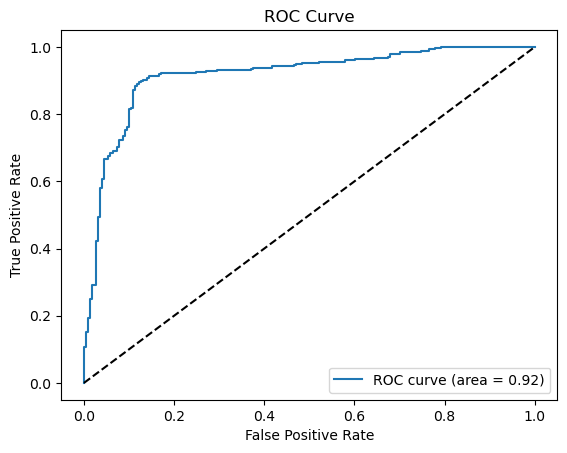

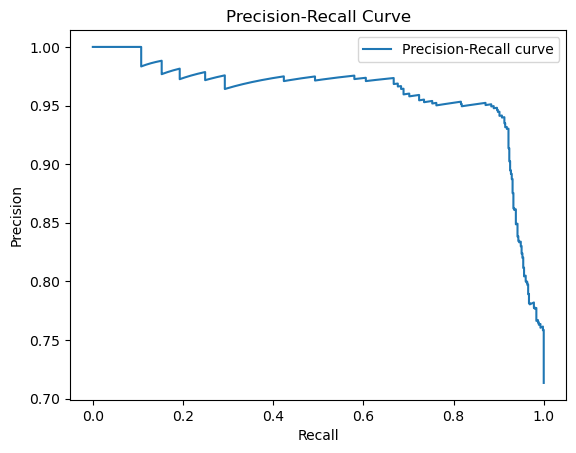

Cross-Validation Scores: [0.70422535 0.6056338  0.76056338 0.6        0.7       ]
Mean CV Accuracy: 0.6740845070422535


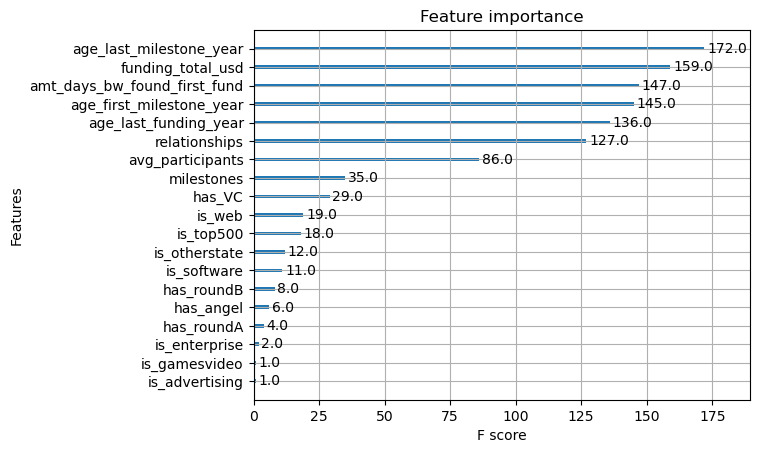

In [20]:
reduced_XGB=xgb_classifier(X_train_reduced, y_train, X_test_reduced, y_test)

## 3. CART

In [21]:
def CART_classifier(X_train, y_train, X_test, y_test):
    
    # Create Decision Tree classifier object
    clf = DecisionTreeClassifier()

    # Train Decision Tree Classifier
    clf = clf.fit(X_train, y_train)

    # Predict the response for the test dataset
    y_pred = clf.predict(X_test)
    
    # Plot Decision Tree
    plt.figure(figsize=(20,10))
    plot_tree(clf, filled=True)
    plt.show()

    # Model Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    
    # Classification Report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    
    # ROC-AUC (only for binary classification)
    if len(set(y_test)) == 2:
        y_pred_prob = clf.predict_proba(X_test)[:,1]
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print("ROC AUC Score:", roc_auc)
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    
    # Feature Importances
    feature_importances = clf.feature_importances_
    indices = np.argsort(feature_importances)[-10:]  # Get the indices of the top features
    plt.figure(figsize=(10,10))
    plt.title('Top 10 Feature Importances'.format(10))
    plt.barh(range(len(indices)), feature_importances[indices], color='lightblue', align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    # Cross-Validation Scores
    cross_val_scores = cross_val_score(clf, X_train, y_train, cv=5)
    print("Cross-Validation Scores:", cross_val_scores)
    print("Mean CV Accuracy:", cross_val_scores.mean())

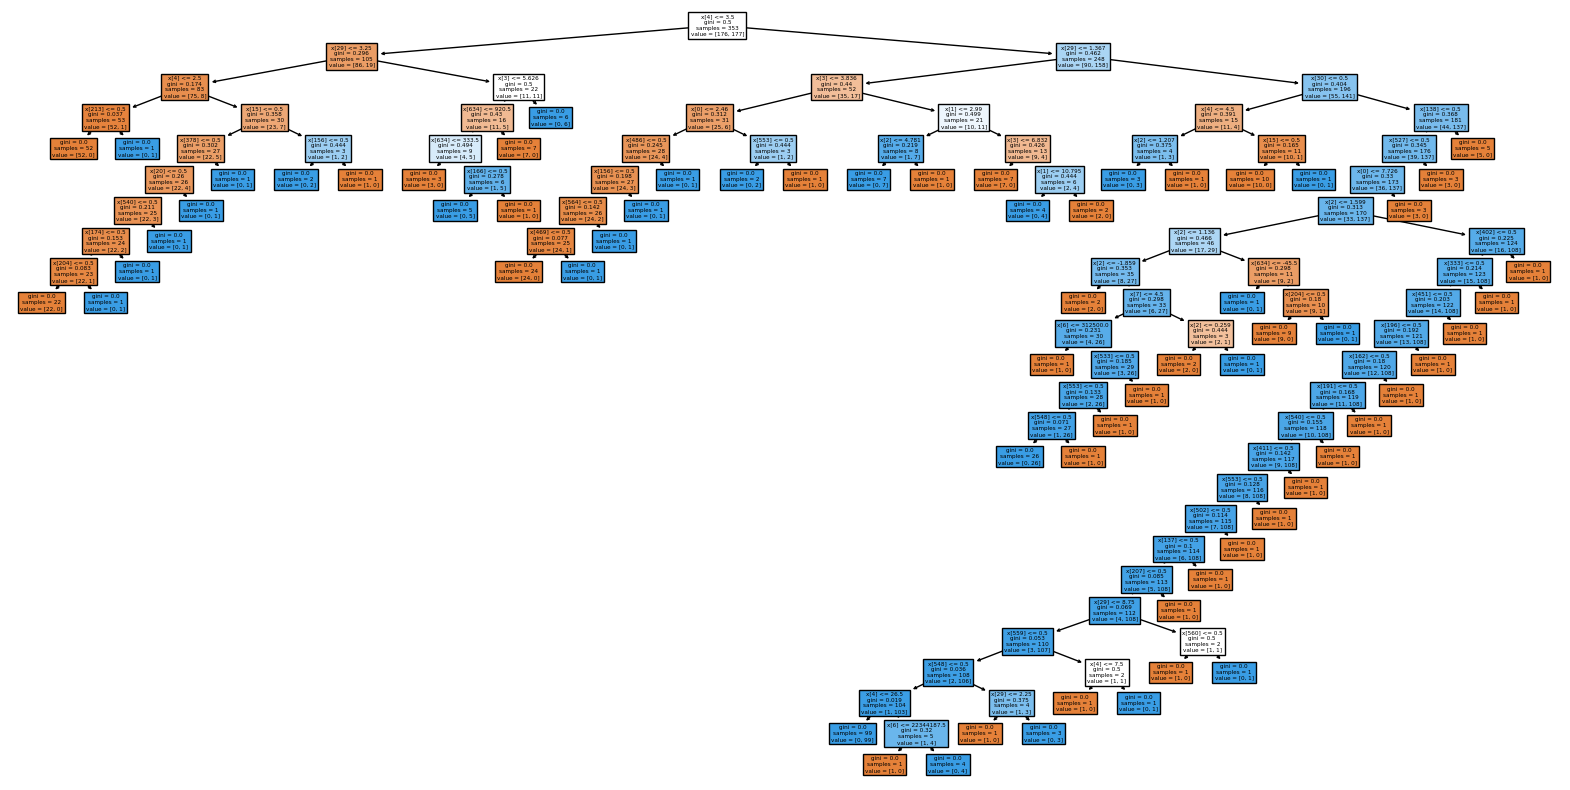

Accuracy: 0.7989623865110247
Confusion Matrix:
 [[201  20]
 [135 415]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.91      0.72       221
           1       0.95      0.75      0.84       550

    accuracy                           0.80       771
   macro avg       0.78      0.83      0.78       771
weighted avg       0.85      0.80      0.81       771

ROC AUC Score: 0.8320238584944467


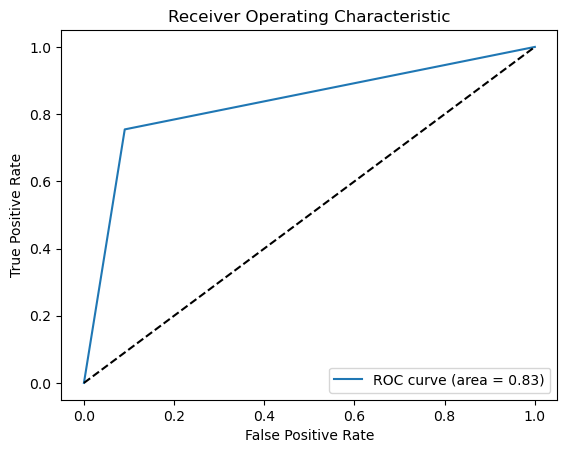

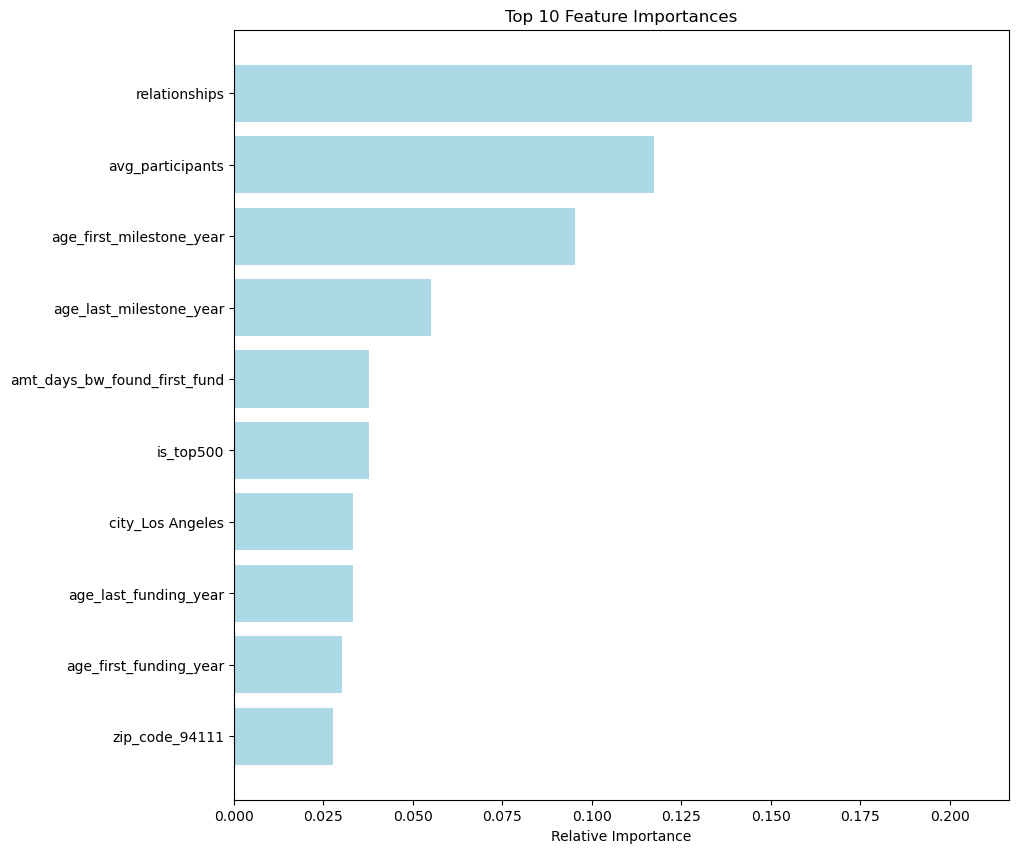

Cross-Validation Scores: [0.73239437 0.64788732 0.64788732 0.64285714 0.62857143]
Mean CV Accuracy: 0.6599195171026156


In [22]:
complete_CART=CART_classifier(X_train, y_train, X_test, y_test)

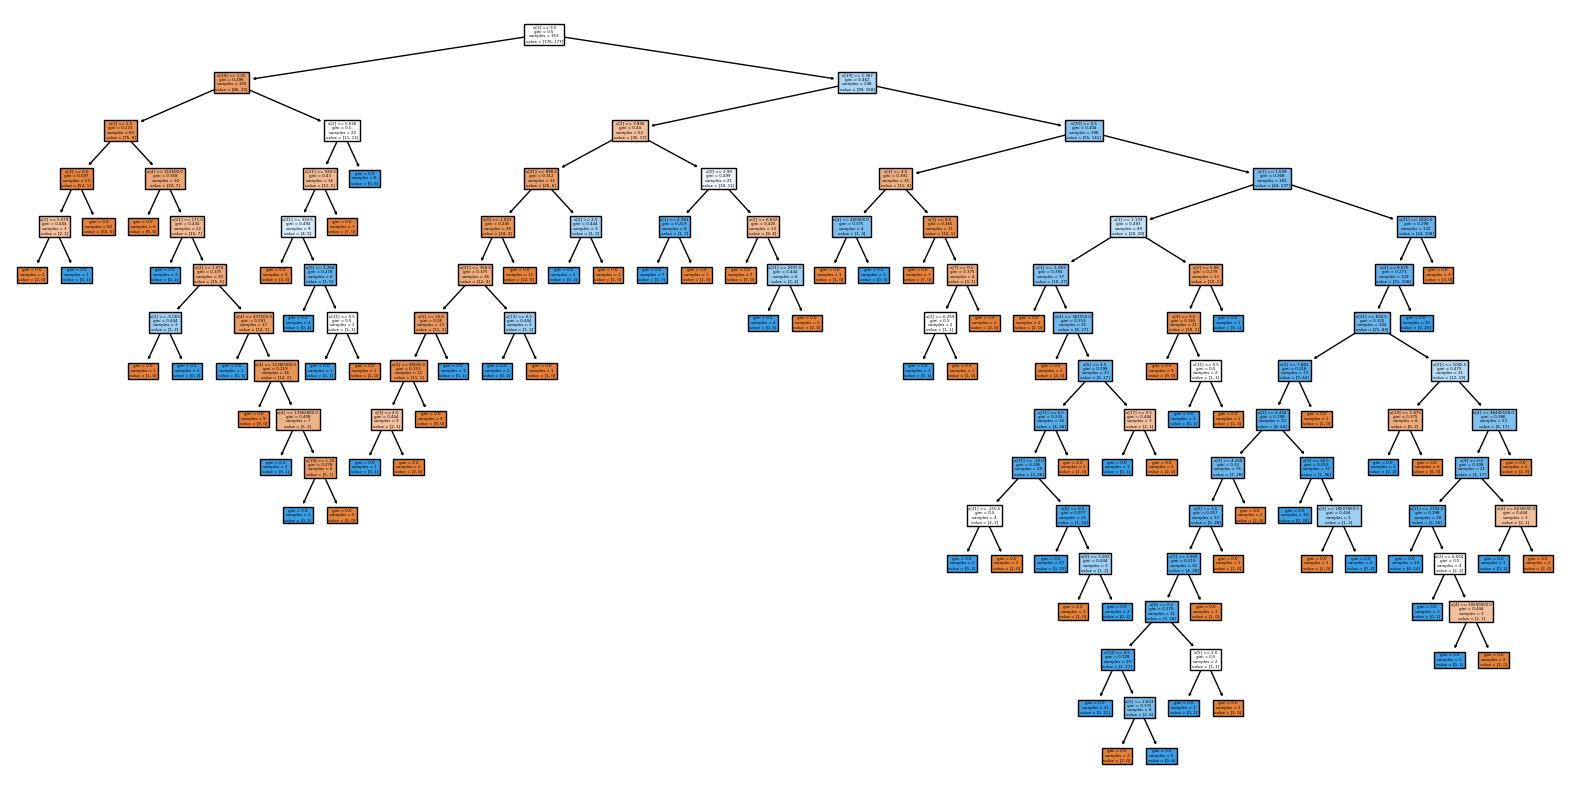

Accuracy: 0.8028534370946823
Confusion Matrix:
 [[203  18]
 [134 416]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.92      0.73       221
           1       0.96      0.76      0.85       550

    accuracy                           0.80       771
   macro avg       0.78      0.84      0.79       771
weighted avg       0.86      0.80      0.81       771

ROC AUC Score: 0.8374578362813656


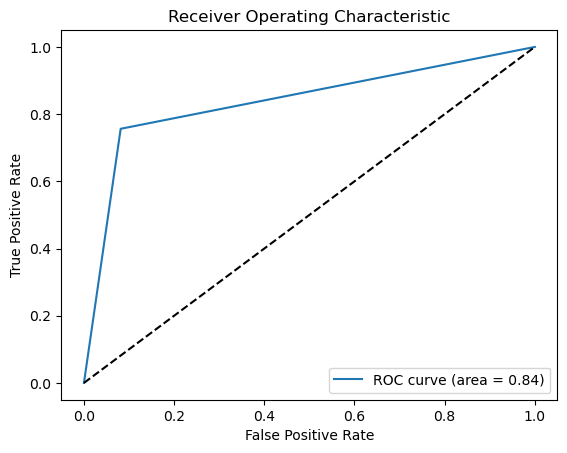

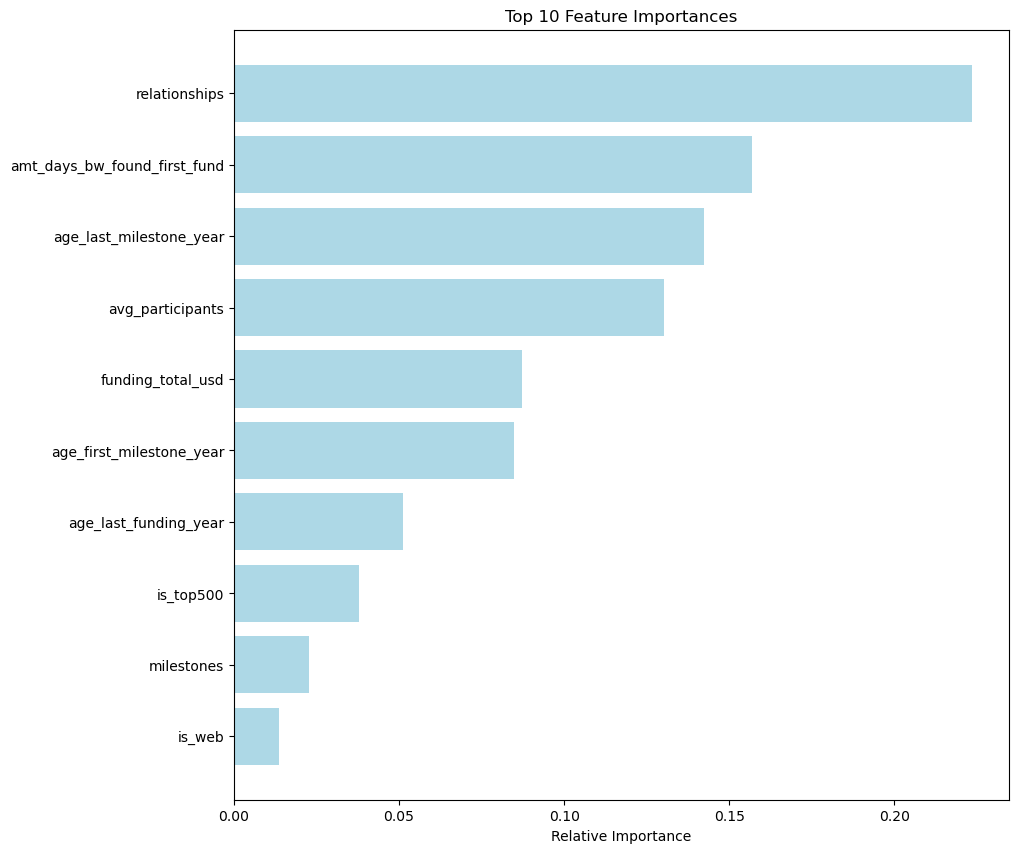

Cross-Validation Scores: [0.66197183 0.6056338  0.6056338  0.54285714 0.64285714]
Mean CV Accuracy: 0.6117907444668008


In [23]:
reduced_CART=CART_classifier(X_train_reduced, y_train, X_test_reduced, y_test)

## 4. Random Forest

In [24]:
def rf_classifier(X_train, y_train, X_test, y_test):
    # Define the parameter grid for Random Forest
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 4, 6, 8, 10]
    }
    
    # Initialize and perform grid search to find the best parameters
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator from grid search
    best_rf_classifier = grid_search.best_estimator_
    
    # Make predictions on the test set
    y_pred = best_rf_classifier.predict(X_test)

    # Compute and print model accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    # Generate and print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    
    # Print classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    
    # Compute ROC-AUC for binary classification
    if len(set(y_test)) == 2:
        y_pred_prob = best_rf_classifier.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print("ROC AUC Score:", roc_auc)
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) - Random Forest')
        plt.legend(loc="lower right")
        plt.show()
    
    # Visualize feature importances
    feature_importances = best_rf_classifier.feature_importances_
    indices = np.argsort(feature_importances)[-10:]  # Top 10 features
    plt.figure(figsize=(10,10))
    plt.title('Top 10 Feature Importances in Random Forest Model')
    plt.barh(range(len(indices)), feature_importances[indices], color='lightblue', align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    # Compute and print cross-validation scores
    cross_val_scores = cross_val_score(best_rf_classifier, X_train, y_train, cv=5)
    print("Cross-Validation Scores:", cross_val_scores)
    print("Mean CV Accuracy:", cross_val_scores.mean())

Accuracy: 0.8391699092088197
Confusion Matrix:
 [[204  17]
 [107 443]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.92      0.77       221
           1       0.96      0.81      0.88       550

    accuracy                           0.84       771
   macro avg       0.81      0.86      0.82       771
weighted avg       0.88      0.84      0.85       771

ROC AUC Score: 0.9350802139037433


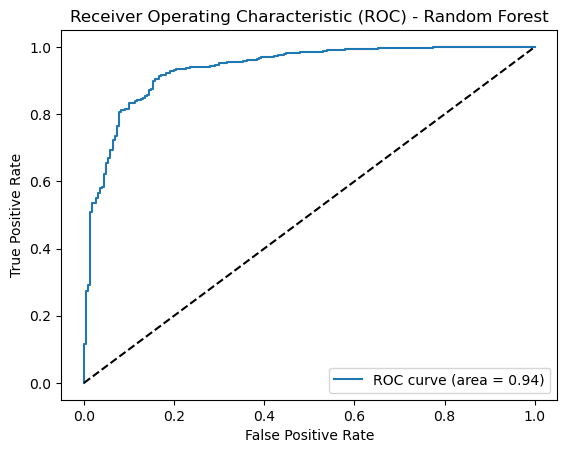

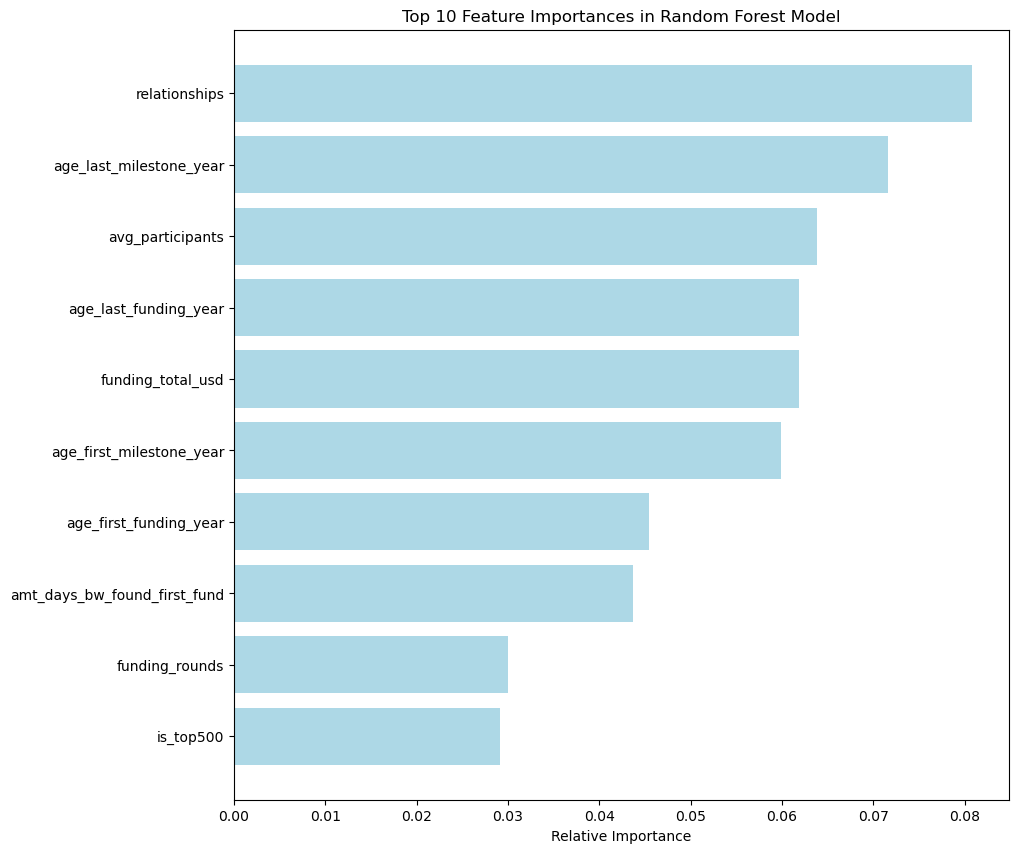

Cross-Validation Scores: [0.71830986 0.66197183 0.78873239 0.67142857 0.7       ]
Mean CV Accuracy: 0.7080885311871226


In [25]:
complete_rf=rf_classifier(X_train, y_train, X_test, y_test)

Accuracy: 0.7704280155642024
Confusion Matrix:
 [[164  57]
 [120 430]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.74      0.65       221
           1       0.88      0.78      0.83       550

    accuracy                           0.77       771
   macro avg       0.73      0.76      0.74       771
weighted avg       0.80      0.77      0.78       771

ROC AUC Score: 0.8512464006581653


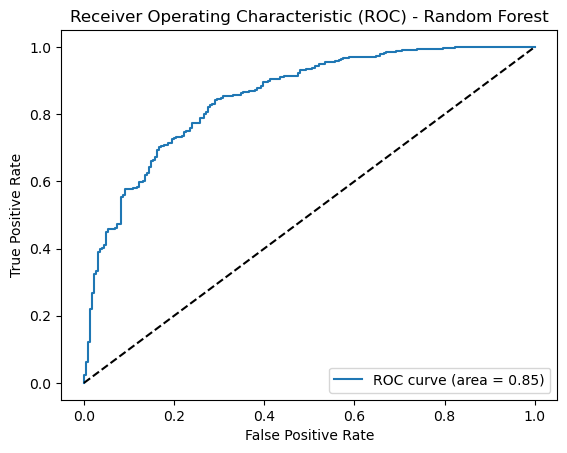

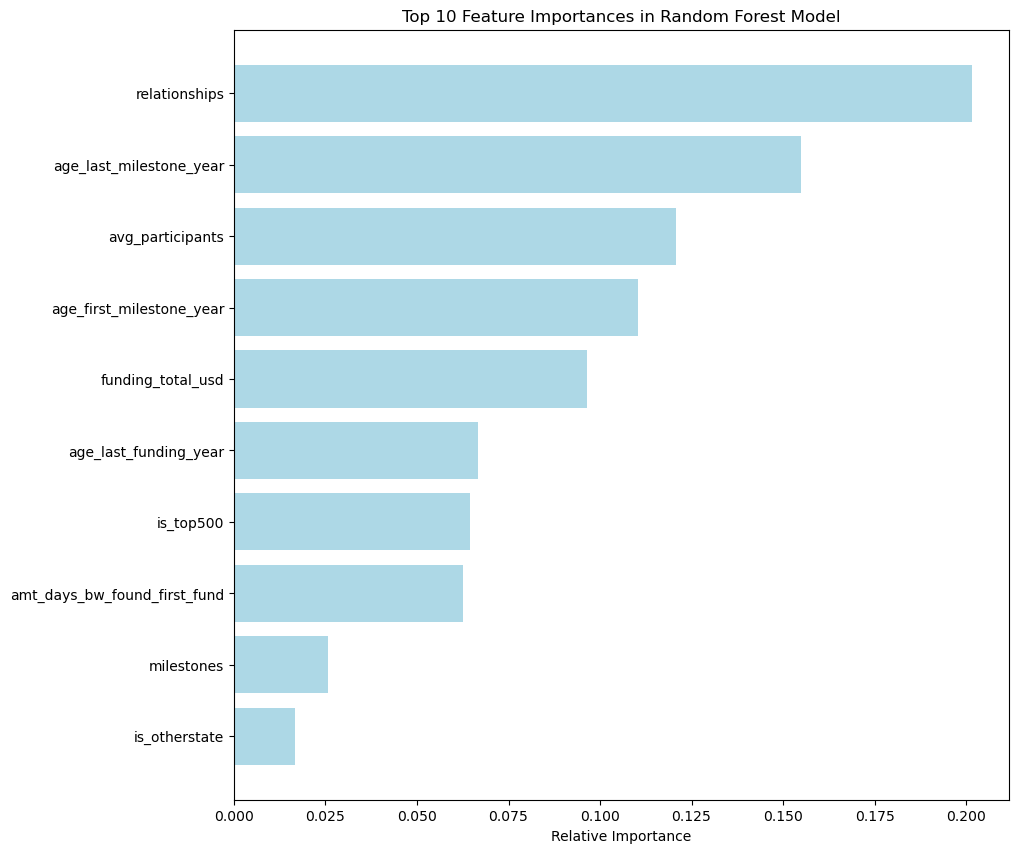

Cross-Validation Scores: [0.74647887 0.66197183 0.81690141 0.7        0.71428571]
Mean CV Accuracy: 0.7279275653923541


In [28]:
reduced_rf=rf_classifier(X_train_reduced, y_train, X_test_reduced, y_test)

## 5. LightGBM

def lgbm_classifier(X_train, y_train, X_test, y_test):
    # Define the parameter grid for LightGBM
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100],
        'max_depth': [5, 10, 20]
    }
    
    # Initialize and perform grid search to find the best parameters
    grid_search = GridSearchCV(LGBMClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator from grid search
    best_lgbm_classifier = grid_search.best_estimator_
    
    # Make predictions on the test set
    y_pred = best_lgbm_classifier.predict(X_test)

    # Compute and print model accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    # Generate and print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    
    # Print classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    
    # Compute ROC-AUC for binary classification
    if len(set(y_test)) == 2:
        y_pred_prob = best_lgbm_classifier.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print("ROC AUC Score:", roc_auc)
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) - LightGBM')
        plt.legend(loc="lower right")
        plt.show()
    
    # Visualize feature importances
    feature_importances = best_lgbm_classifier.feature_importances_
    indices = np.argsort(feature_importances)[-10:]  # Top 10 features
    plt.figure(figsize=(10,10))
    plt.title('Top 10 Feature Importances in LightGBM Model')
    plt.barh(range(len(indices)), feature_importances[indices], color='lightblue', align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    # Compute and print cross-validation scores
    cross_val_scores = cross_val_score(best_lgbm_classifier, X_train, y_train, cv=5)
    print("Cross-Validation Scores:", cross_val_scores)
    print("Mean CV Accuracy:", cross_val_scores.mean())

complete_lgbm=lgbm_classifier(X_train, y_train, X_test, y_test)

reduced_lgbm=lgbm_classifier(X_train_reduced, y_train, X_test_reduced, y_test)

## 6. Support Vector Machines

def svm_classifier(X_train, y_train, X_test, y_test):
    # Define the parameter grid for SVM
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }
    
    # Initialize and perform grid search to find the best parameters
    grid_search = GridSearchCV(SVC(random_state=42, probability=True), param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator from grid search
    best_svm_classifier = grid_search.best_estimator_
    
    # Make predictions on the test set
    y_pred = best_svm_classifier.predict(X_test)

    # Compute and print model accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    # Generate and print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    
    # Print classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    
    # Compute ROC-AUC for binary classification
    if len(set(y_test)) == 2:
        y_pred_prob = best_svm_classifier.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print("ROC AUC Score:", roc_auc)
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) - SVM')
        plt.legend(loc="lower right")
        plt.show()
    
    # Feature importance is not typically applicable for SVM models
    
    # Compute and print cross-validation scores
    cross_val_scores = cross_val_score(best_svm_classifier, X_train, y_train, cv=5)
    print("Cross-Validation Scores:", cross_val_scores)
    print("Mean CV Accuracy:", cross_val_scores.mean())

complete_svm=svm_classifier(X_train, y_train, X_test, y_test)

reduced_svm=svm_classifier(X_train_reduced, y_train, X_test_reduced, y_test)